In [1]:
import numpy as np
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)


RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)

import pymc as pm
import aesara.tensor as at
import aesara

# Bayesian analysis of Lucia's rock types

In [1995, Lucia](https://doi.org/10.1306/7834D4A4-1721-11D7-8645000102C1865D) published a method for using rock fabric to classify carbonate rocks. These classifications have been used industry-wide to estimate permeability from porosity. Let's re-analyze Figure 12, which shows permeability versus interparticle porosity for Lucia's three rock classes.


In [2]:
data = pd.read_csv("data/Lucia_Poroperm_Male.csv")
data["log_porosity"] = data["Porosity"].apply(np.log).astype(aesara.config.floatX)
data["log_permeability"] = (
    data["Permeability"].apply(np.log).astype(aesara.config.floatX)
)
class_idx, class_id = pd.factorize(data["Class"])
coords = {"Class": class_id, "obs_id": np.arange(len(class_idx))}

In the paper, Lucia provides three regression lines.

Class 1:
$\begin{equation}
k=(45.35\times10^8)\times\phi_{ip}^{8.537}
\end{equation}$
Class 2:
$\begin{equation}
k=(2.040\times10^6)\times \phi_{ip}^{6.38}
\end{equation}$
Class 3:
$\begin{equation}
k=(2.884\times10^3)\times \phi_{ip}^{4.275}
\end{equation}$

But one question unanswered: Are these different slopes and intercepts statistically significant?

Our first stop is frequentist least-squares regression:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_permeability   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     174.2
Date:                Thu, 07 Sep 2023   Prob (F-statistic):          1.03e-100
Time:                        01:23:47   Log-Likelihood:                -702.39
No. Observations:                 433   AIC:                             1417.
Df Residuals:                     427   BIC:                             1441.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     14.4995      0.765     18.964      0.000      12.997      16.002
C(Class)[T.2]                 -3.1086      0.955     -3.256      0.001      -4.985      -1.232
C(Class)[T.3]                 -7.7745      0.859     -9.052      0.000      -9.463      -6.086
log_porosity                   5.0948      0.335     15.211      0.000       4.436       5.753
log_porosity:C(Class)[T.2]    -0.3201      0.436     -0.734      0.463      -1.178       0.537
log_porosity:C(Class)[T.3]    -1.6958      0.410     -4.141      0.000      -2.501      -0.891
==============================================================================
Omnibus:                        3.915   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.852
Skew:                           0.231   Prob(JB):                        0.146
Kurtosis:                       3.001   Cond. No.                         62.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

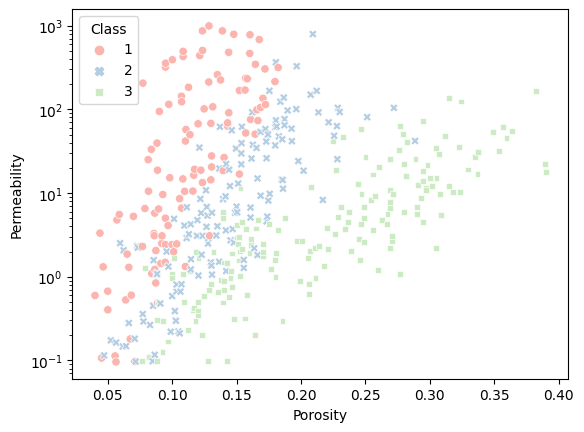

In [3]:
g = sns.scatterplot(
    data, x="Porosity", y="Permeability", hue="Class", palette="Pastel1", style="Class"
)
g.set(yscale="log")
ols = smf.ols(formula="log_permeability ~ log_porosity * C(Class)", data=data).fit()
ols.summary()

And it appears that the difference in log-perm slope between classes 1 and 2 might not be statistically significant. Let's run a hierarchical model with pymc and see what falls out:

The model looks like
$\begin{equation}
\ln k_i = a(\textrm{Class}_i) \sigma_a + \mu_a + \left[b(\textrm{Class}_i) \sigma_b + \mu_b\right] \ln \phi_i + \epsilon_i 
\end{equation}$

where $i$ is the sample number, $\textrm{Class}_i$ is the class of the sample, $\mu_a$ and $\mu_b$ are the population intercepts and slopes, $\phi_i$ is porosity, and $\epsilon_i$ is the sample error. $a$ and $b$ relate to how the class changes the intercept and slope of log permeability.


In [4]:
with pm.Model(coords=coords) as model:
    # Intercepts
    mu_a = pm.Normal("mu_a", mu=11.0, sigma=2)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    a = pm.Normal("a", dims="Class") * sigma_a + mu_a

    # Slopes, non-centered
    mu_b = pm.Normal("mu_b", mu=5.0, sigma=2.0)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)
    b = pm.Normal("b", dims="Class") * sigma_b + mu_b

    eps = pm.HalfNormal("eps", 3.0)

    log_perm_est = a[class_idx] + b[class_idx] * data["log_porosity"].values

    log_perm_like = pm.Normal(
        "log_perm_like",
        mu=log_perm_est,
        sigma=eps,
        observed=data["log_permeability"],
        dims="obs_id",
    )
    idata = pm.sample(target_accept=0.9)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

/home/frank/Dropbox/ROZ/code/bayes-lucia/venv/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chai

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [log_perm_like]


In [5]:
# Run posterior predictive checks
posterior = idata.posterior
log_porosity = np.random.normal(
    data["log_porosity"].mean(),
    data["log_porosity"].std(),
    size=posterior["mu_a"].shape,
)
data_ppc = (
    pd.concat(
        [
            pd.DataFrame(
                {
                    "log_porosity": log_porosity.ravel(),
                    "Class": class_id,
                    "y_pred": (
                        posterior["mu_a"]
                        + posterior["a"].sel(Class=class_id) * posterior["sigma_a"]
                        + (
                            posterior["mu_b"]
                            + posterior["b"].sel(Class=class_id) * posterior["sigma_b"]
                        )
                        * log_porosity
                    )
                    .to_numpy()
                    .ravel(),
                }
            )
            for class_id in range(1, 4)
        ]
    )
    .assign(
        y_like=lambda x: x.y_pred
        * np.random.normal(
            loc=1, scale=np.repeat(posterior["eps"].to_numpy().ravel(), 3)
        )
    )
    .assign(
        porosity=lambda x: np.exp(x.log_porosity),
        permeability=lambda x: np.exp(x.y_pred),
        permeability_like=lambda x: np.exp(x.y_like),
    )
)

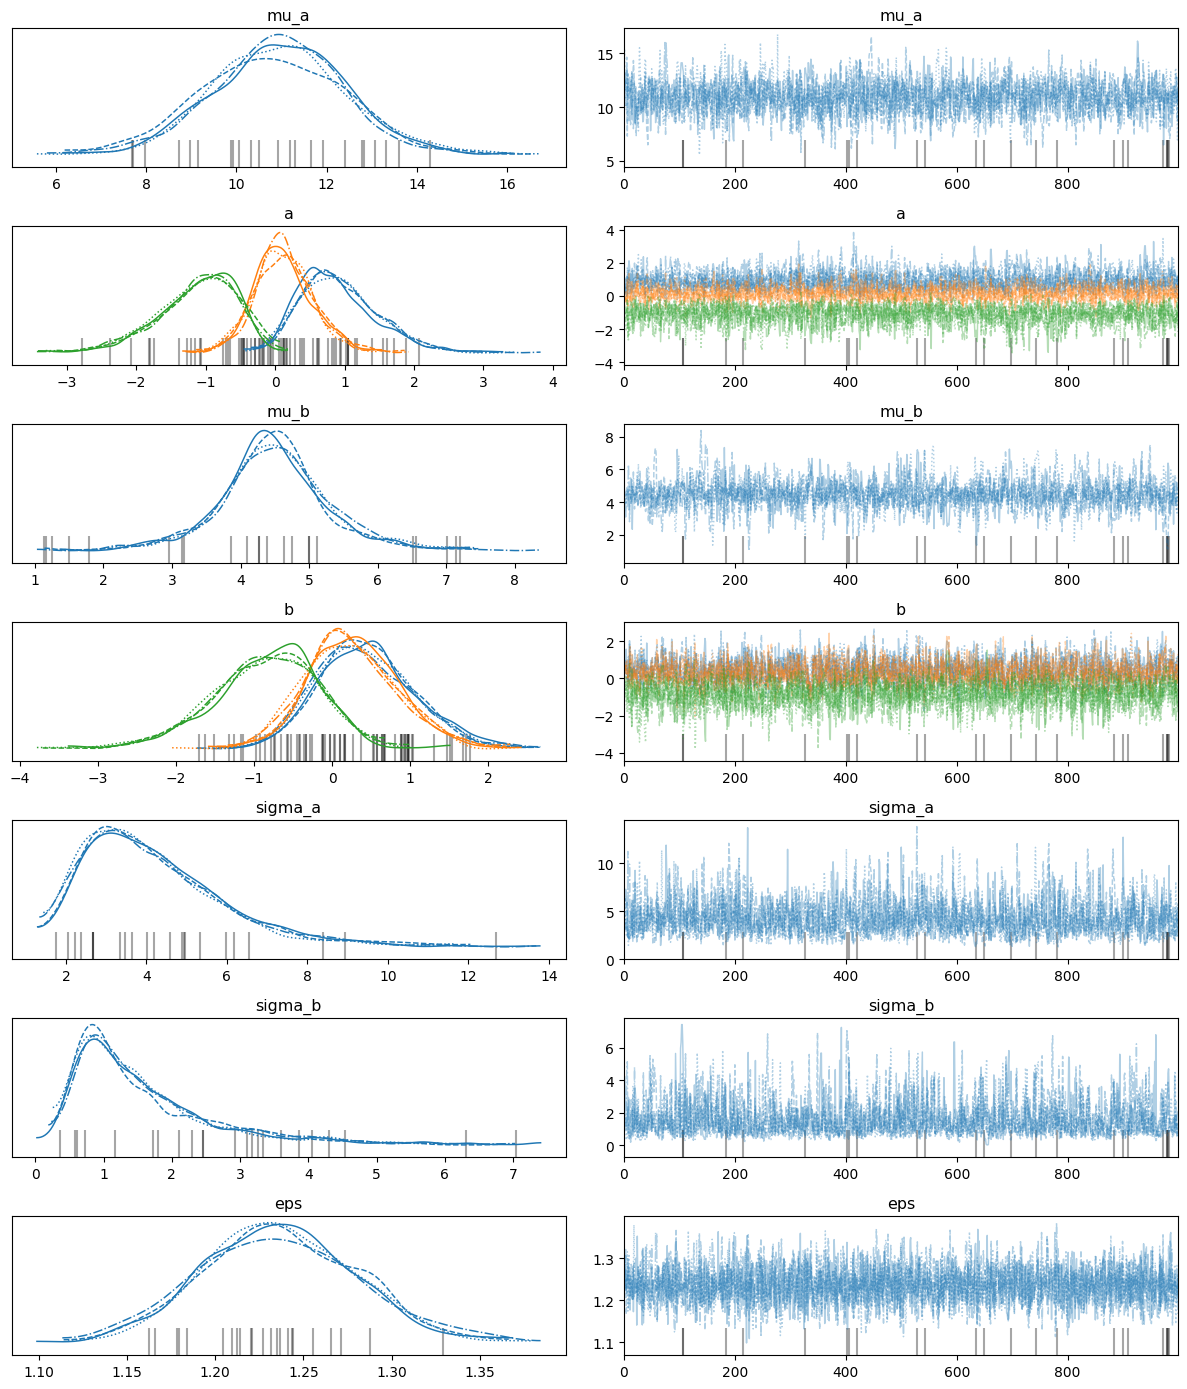

In [6]:
az.plot_trace(idata)
plt.tight_layout()

Okay, there's significant overlap between the posterior distributions of $a$, the class dependence for intercept, and $b$ the slope's dependence on class. Interesting.


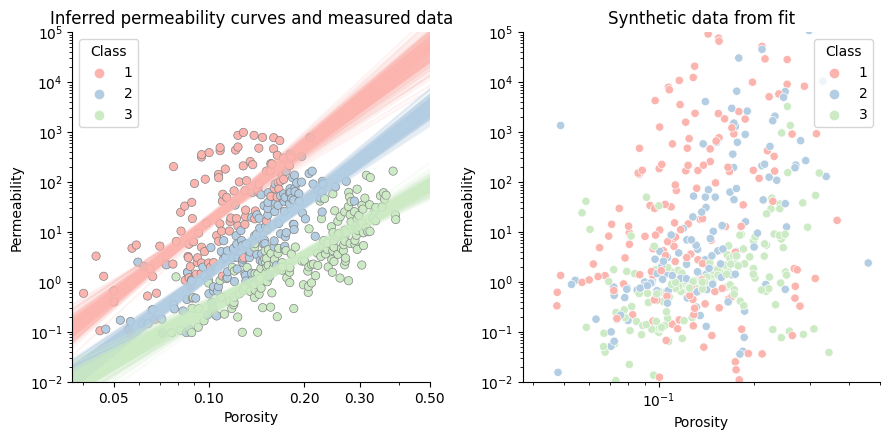

In [7]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))
porosity = np.linspace(0.001, 0.5, 100)
for class_id in [1, 2, 3]:
    intercept = (
        (posterior["mu_a"] + posterior["a"].sel(Class=class_id) * posterior["sigma_a"])
        .to_numpy()
        .ravel()
    )
    slope = (
        (posterior["mu_b"] + posterior["b"].sel(Class=class_id) * posterior["sigma_b"])
        .to_numpy()
        .ravel()
    )
    for i in np.random.choice(range(len(slope)), 200):
        permeability = np.exp(intercept[i] + slope[i] * np.log(porosity))
        ax.plot(
            porosity,
            permeability,
            color=sns.color_palette("Pastel1")[class_id - 1],
            alpha=0.15,
        )
axis_args = dict(
    yscale="log",
    xscale="log",
    xlabel="Porosity",
    ylabel="Permeability",
    title="Inferred permeability curves and measured data",
    ylim=(1e-2, 1e5),
    xlim=(3.7e-2, 0.5),
)
ax.set(**axis_args)
ax.set_xticks([0.05, 0.1, 0.2, 0.3, 0.5])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


sns.despine()
g = sns.scatterplot(
    data,
    x="Porosity",
    y="Permeability",
    hue="Class",
    ax=ax,
    palette="Pastel1",
    edgecolor="gray",
)


g2 = sns.scatterplot(
    data=data_ppc.sample(500),
    x="porosity",
    y="permeability_like",
    hue="Class",
    palette="Pastel1",
    ax=ax2,
)
g2.set(**axis_args)
g2.set(title="Synthetic data from fit")
ax.set_xticks([0.05, 0.1, 0.2, 0.3, 0.5])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.tight_layout()
sns.despine()
fig.savefig("lucia_permeability.png", dpi=500)

Interesting. A few things pop out:

1. There's more uncertainty in the mean permeability, given porosity and class, than expected.
2. There's way more variation in permeability given porosity in the synthetic data than the input data. What's going on?

If the individual results were as tightly bound as our predictions of the means, the permeability scatter would look like this:


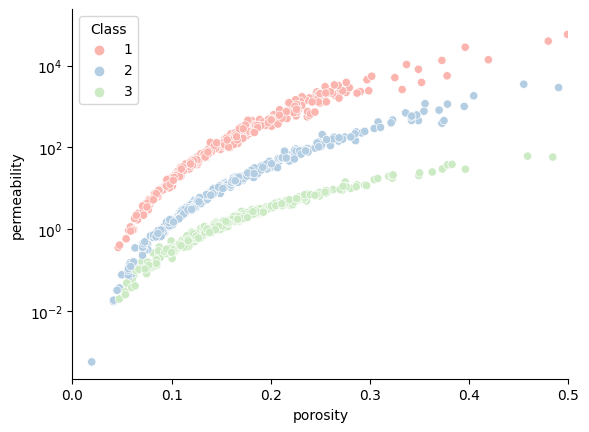

In [8]:
g = sns.scatterplot(
    data=data_ppc.sample(1000),
    x="porosity",
    y="permeability",
    hue="Class",
    palette="Pastel1",
)
g.set(yscale="log", xlim=(0, 0.5))
sns.despine()

This is an example of the [difference between inferential and predictive uncertainty](https://www.pnas.org/doi/10.1073/pnas.2302491120).

But back to discovery 2. Let's look at some more posterior predictive checks. What's the log perm look like?


<Axes: xlabel='log_perm_like / log_perm_like'>

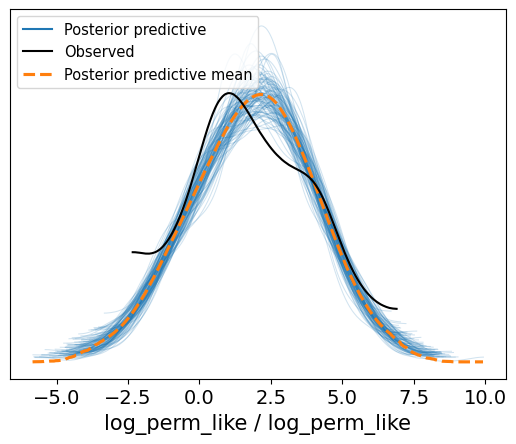

In [9]:
az.plot_ppc(idata, num_pp_samples=100)

Weird. Why the double hump in the observations? Well, if you read my paper with Ian Duncan [on permeability transforms for carbonates](https://eartharxiv.org/repository/view/636/) (and bless you if you did), you saw that the porosity distribution in Lucia's figure is a little wonky.


<Axes: xlabel='Porosity', ylabel='Class'>

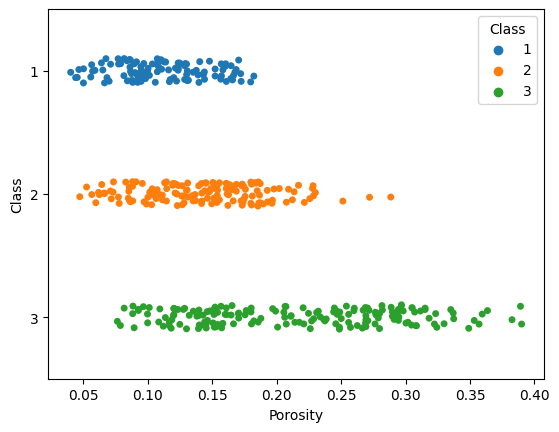

In [10]:
sns.stripplot(
    data.assign(Class=data.Class.astype("category")),
    x="Porosity",
    y="Class",
    hue="Class",
)

Okay, that mystery solved (Or is it?), here are some other diagnostic plots from the Bayesian analysis.


<Axes: >

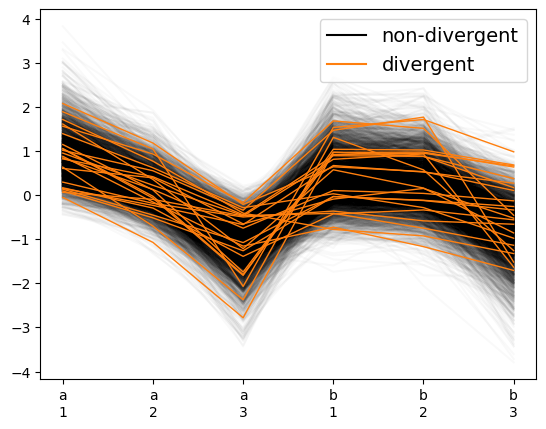

In [11]:
az.plot_parallel(idata, var_names=["a", "b"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

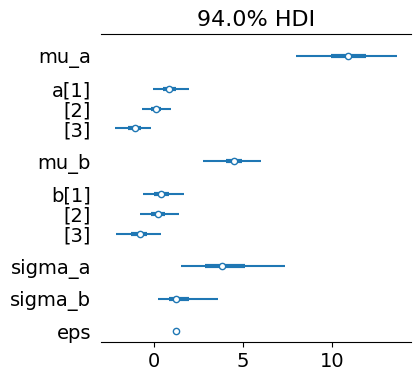

In [12]:
az.plot_forest(
    idata,
    combined=True,
    figsize=(4, 4),
)

And a fun version of the poro-perm plot, but with linear porosity


[None,
 (0.0, 0.5),
 Text(0, 0.5, 'Permeability with modeled noise'),
 (1e-06, 1000000.0)]

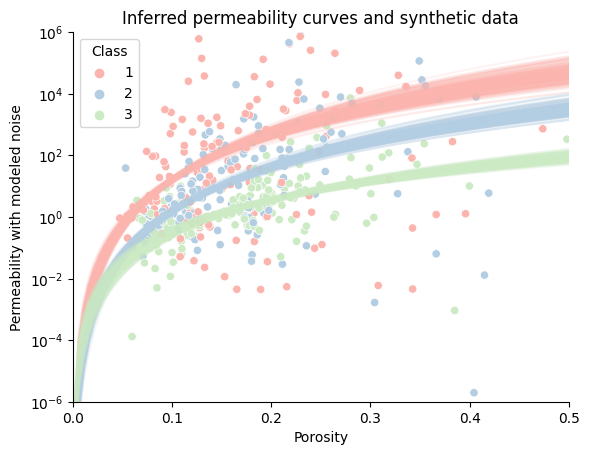

In [13]:
fig, ax = plt.subplots()
porosity = np.linspace(0.001, 0.5, 100)
for class_id in [1, 2, 3]:
    intercept = (
        (posterior["mu_a"] + posterior["a"].sel(Class=class_id) * posterior["sigma_a"])
        .to_numpy()
        .ravel()
    )
    slope = (
        (posterior["mu_b"] + posterior["b"].sel(Class=class_id) * posterior["sigma_b"])
        .to_numpy()
        .ravel()
    )
    for i in np.random.choice(range(len(slope)), 200):
        permeability = np.exp(intercept[i] + slope[i] * np.log(porosity))
        ax.plot(
            porosity,
            permeability,
            color=sns.color_palette("Pastel1")[class_id - 1],
            alpha=0.15,
        )
ax.set(
    yscale="log",
    xlabel="Porosity",
    ylabel="Permeability",
    title="Inferred permeability curves and synthetic data",
)
sns.despine()

# plt.figure()
g2 = sns.scatterplot(
    data=data_ppc.sample(500),
    x="porosity",
    y="permeability_like",
    hue="Class",
    palette="Pastel1",
    ax=ax,
)
g2.set(
    yscale="log",
    xlim=(0, 0.5),
    ylabel="Permeability with modeled noise",
    ylim=(1e-6, 1e6),
)
# sns.despine()